> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In [56]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [57]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 256

In [58]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [59]:
# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/mnist")
train_dataset = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)

In [60]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int64)
y_test  = np.array(test_dataset.targets, dtype=np.int64)

C:\Users\Joshua\AppData\Local\Temp\ipykernel_5352\1224777063.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train = np.array(train_dataset.data, dtype=np.float)
C:\Users\Joshua\AppData\Local\Temp\ipykernel_5352\1224777063.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_test = np.array(test_dataset.data, dtype=np.float)


(-0.5, 27.5, 27.5, -0.5)

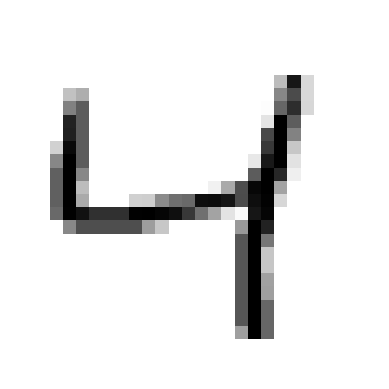

In [61]:
# Here we plot one of the raw data points as an example
data_id = 2
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

In [ ]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

In [66]:
def images2spike(x, y, nb_steps, batch_size, shuffle, **kwargs):  
    '''Converts images to spike trains'''
    labels_ = np.array(y,dtype=np.int64)
    number_of_batches = len(x)//batch_size
    sample_index = np.arange(len(x))

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0

    batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
    while counter < number_of_batches:
        x_batch = torch.empty((len(x[batch_index]), nb_steps, nb_inputs)).to(device)
        for i, image in enumerate(x[batch_index]):
            tensor_image = torch.Tensor(image)
            spike_train = torch.empty((nb_steps, nb_inputs))
            
            spike_t = snntorch.spikegen.rate(tensor_image, num_steps = nb_steps)
                
            x_batch[i] = spike_train
        y_batch = torch.tensor(labels_[batch_index],device=device) 

        yield x_batch,  y_batch

        counter += 1

In [67]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [68]:
weight_scale = 0.006

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale)

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale)

print("init done")

init done


In [69]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [71]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha*syn +h1[:,t]
        new_mem = (beta*mem +syn)*(1.0-rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [72]:
def train(x_data, y_data, nb_steps, lr=1e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in images2spike(x_data, y_data, nb_steps, batch_size, shuffle=True):
            output,recs = run_snn(x_local)
            _,spks=recs
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            
            # Here we set up our regularizer loss
            # The strength paramters here are merely a guess and there should be ample room for improvement by
            # tuning these paramters.
            reg_loss = 1e-7*torch.sum(spks) # L1 loss on total number of spikes
            reg_loss += 1e-8*torch.mean(torch.sum(torch.sum(spks,dim=0),dim=0)**2) # L2 loss on spikes per neuron
            
            # Here we combine supervised loss and the regularizer
            loss_val = loss_fn(log_p_y, y_local) + reg_loss

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data, scale, batch_size, shuffle, **kwargs):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in images2spike(x_data, y_data,scale, batch_size, shuffle=True, **kwargs):
        output,_ = run_snn(x_local)
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [73]:
loss_hist = train(x_train, y_train, nb_steps, lr=1e-4, nb_epochs=30)

In [ ]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [ ]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train, scale=4, batch_size=256, shuffle=False)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test, scale=4, batch_size=256, shuffle=False)))

In [ ]:
def get_mini_batch(x_data, y_data):
    for ret in images2spike(x_data, y_data, scale=4, batch_size=256, shuffle=False):
        return ret 

In [ ]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn(x_batch.to_dense())
mem_rec, spk_rec = other_recordings

In [ ]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

In [ ]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()